In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("metrics.csv")

In [34]:
# Fix standalone sites
mapping = [("KITS", "Kidney"), ("LVR", "Liver"), ("PAN", "Pancreas"), ("SPL", "Spleen")]
for key, site in mapping:
    df.update(
        df[(df.Algorithm == "Standalone") & df.ID.str.contains(key)].assign(Site=site)
    )
df[df.Algorithm == "FedOpt"]

,ID,Algorithm,Site,Kidney,Kidney Tumor,Liver,Liver Tumor,Pancreas,Pancreas Tumor,Spleen,Average
1452,IM_KITS_051.nii.gz,FedOpt,Server,0.942606,0.582901,NaN,NaN,NaN,NaN,NaN,0.762753
1453,IM_KITS_107.nii.gz,FedOpt,Server,0.900179,0.932831,NaN,NaN,NaN,NaN,NaN,0.916505
1454,IM_KITS_063.nii.gz,FedOpt,Server,0.960689,0.002995,NaN,NaN,NaN,NaN,NaN,0.481842
1455,IM_KITS_046.nii.gz,FedOpt,Server,0.945227,0.925882,NaN,NaN,NaN,NaN,NaN,0.935555
1456,IM_KITS_127.nii.gz,FedOpt,Server,0.970481,0.899397,NaN,NaN,NaN,NaN,NaN,0.934939
...,...,...,...,...,...,...,...,...,...,...,...
2107,IM_SPL_52.nii.gz,FedOpt,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.969346,0.969346
2108,IM_SPL_21.nii.gz,FedOpt,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.959831,0.959831
2109,IM_SPL_26.nii.gz,FedOpt,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.977886,0.977886
2110,IM_SPL_10.nii.gz,FedOpt,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.960043,0.960043


In [35]:
df = df[df.Algorithm != "Standalone"]

In [36]:
kd = pd.read_csv("kd.csv")
kd.update(kd[kd.Site == "server"].assign(Site="Server"))
kd.update(kd[kd.Site == "kidney"].assign(Site="Kidney"))
kd.update(kd[kd.Site == "liver"].assign(Site="Liver"))
kd.update(kd[kd.Site == "pancreas"].assign(Site="Pancreas"))
kd.update(kd[kd.Site == "spleen"].assign(Site="Spleen"))
kd.insert(0, "Algorithm", "Kim et al.")
kd.insert(0, "ID", [os.path.basename(f) for f in kd["Case"]])
average = np.stack([
    kd["Kidney"], kd["Kidney Tumor"],
    kd["Liver"], kd["Liver Tumor"], 
    kd["Pancreas"], kd["Pancreas Tumor"],
    kd["Spleen"]
])
average = np.nanmean(average, axis=0)
kd.insert(12, "Average", average)
del kd["Case"]
del kd["Dataset"]

kd

,ID,Algorithm,Site,Kidney,Kidney Tumor,Liver,Liver Tumor,Pancreas,Pancreas Tumor,Spleen,Average
0,IM_KITS_157.nii.gz,Kim et al.,Server,0.967655,0.945961,NaN,NaN,NaN,NaN,NaN,0.956808
1,IM_KITS_204.nii.gz,Kim et al.,Server,0.973764,0.936577,NaN,NaN,NaN,NaN,NaN,0.955170
2,IM_KITS_093.nii.gz,Kim et al.,Server,0.944217,0.373061,NaN,NaN,NaN,NaN,NaN,0.658639
3,IM_KITS_138.nii.gz,Kim et al.,Server,0.969925,0.840129,NaN,NaN,NaN,NaN,NaN,0.905027
4,IM_KITS_150.nii.gz,Kim et al.,Server,0.972183,0.840640,NaN,NaN,NaN,NaN,NaN,0.906411
...,...,...,...,...,...,...,...,...,...,...,...
655,IM_SPL_32.nii.gz,Kim et al.,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.921162,0.921162
656,IM_SPL_3.nii.gz,Kim et al.,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.937327,0.937327
657,IM_SPL_53.nii.gz,Kim et al.,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.939702,0.939702
658,IM_SPL_10.nii.gz,Kim et al.,Spleen,NaN,NaN,NaN,NaN,NaN,NaN,0.955003,0.955003


In [41]:
df = pd.concat([df[df.Algorithm != "ConDistFL"], kd, df[df.Algorithm == "ConDistFL"]]).reset_index(drop=True)

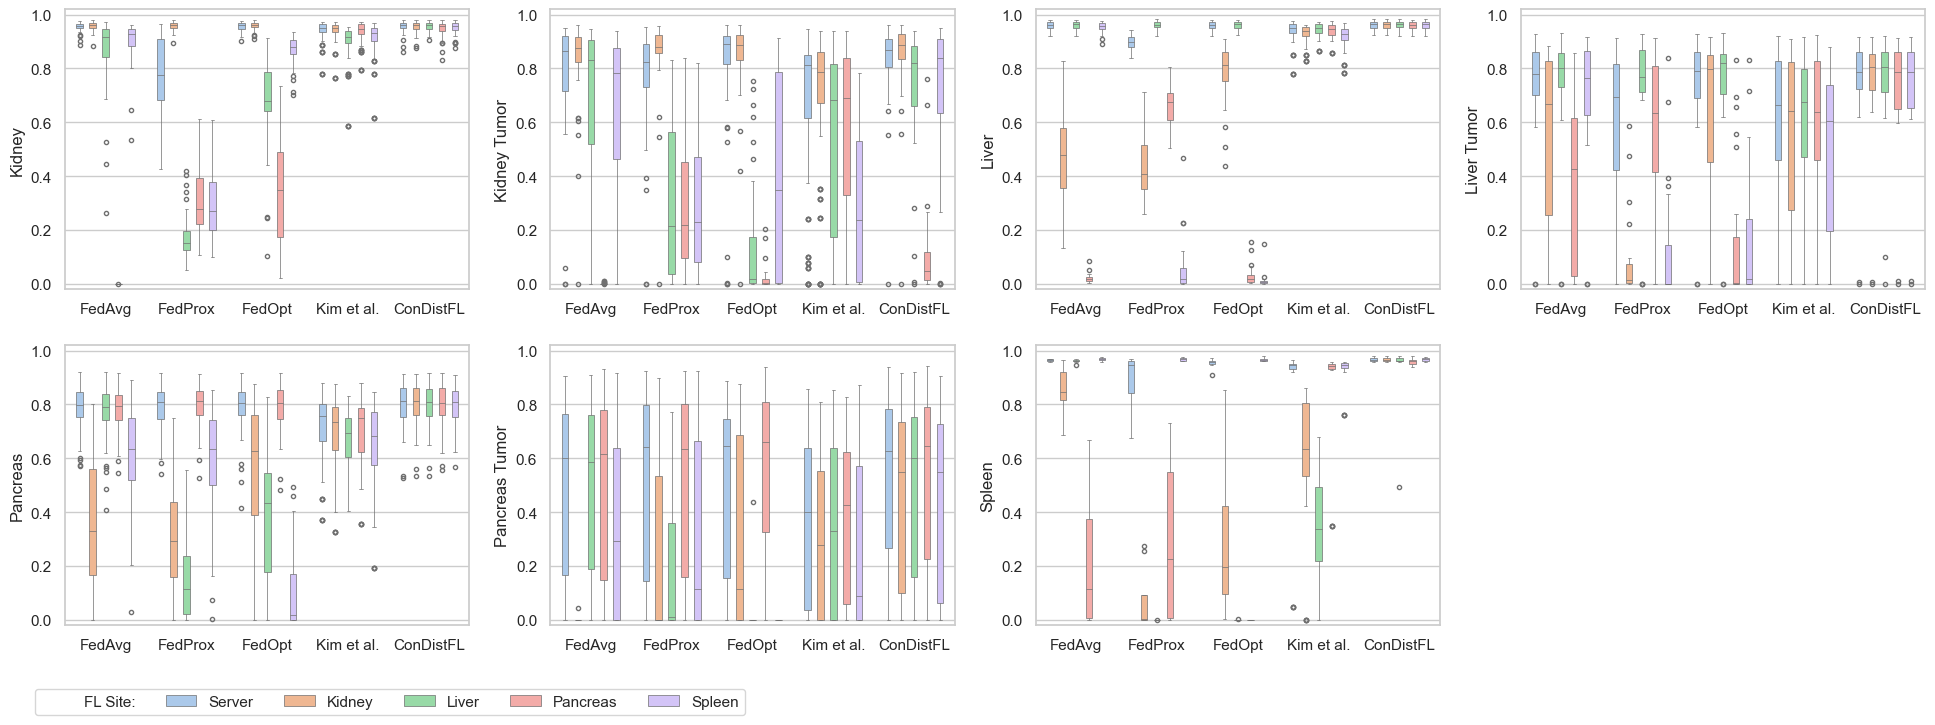

In [96]:
sns.set_theme(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(2, 4, sharey=False, figsize=(24,8))

plots = [
    ("Kidney", 0, 0),
    ("Kidney Tumor", 0, 1),
    ("Liver", 0, 2),
    ("Liver Tumor", 0, 3),
    ("Pancreas", 1, 0),
    ("Pancreas Tumor", 1, 1),
    ("Spleen", 1, 2)
]
for site, x, y in plots:
    sns.boxplot(
        df,
        x="Algorithm",
        y=site,
        hue="Site",
        hue_order=["Server", "Kidney", "Liver", "Pancreas", "Spleen"],
        gap=0.5,
        linewidth=0.5,
        fliersize=3,
        ax=axes[x, y]
    )
    axes[x, y].set_xlabel("")
    axes[x, y].set_ylim([-0.02, 1.02])
    if x == 1 and y == 1:
        h, l = axes[x, y].get_legend_handles_labels()
        ph = [plt.plot([],marker="", ls="")[0]]
        handles = ph + h
        labels = ["FL Site:"] + l
        axes[x, y].legend(handles, labels, ncol=6, bbox_to_anchor=(0.5, -0.20))
        # sns.move_legend(axes[x, y], "lower left", bbox_to_anchor=(0.5, -0.30))
    else:
        axes[x, y].get_legend().remove()

# Bottom right
axes[1, 3].set_axis_off()

plt.savefig("figure.pdf", format="pdf", bbox_inches="tight")